In [ ]:
import duckdb
import pandas as pd

dbs = pd.read_csv('dbs.csv')
eds = pd.read_csv('eds.csv')
lbs = pd.read_csv('lbs.csv')
wrs = pd.read_csv('wrs.csv')

tot = pd.read_csv('agged_season_stats.csv')


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt

drop_cols = [
    'index', 'player_id', 'player', 'pff_player_id', 'position', 'unit',
    'season_1', 'position_1', 'season',
    'coverage_rank', 'offense_rank', 'defense_rank',
    'run_defense_rank', 'pass_rush_rank', 'receiving_rank',
    'pass_rank', 'run_block_rank', 'pass_block_rank', 'run_rank'
]

tot_clean = tot.drop(columns=[c for c in drop_cols if c in tot.columns])
# tot_clean

target_cols = ['wick_score', 'capped_wick_score']
X = tot_clean.drop(columns=target_cols)
y = tot_clean[target_cols]

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y['wick_score'], test_size=0.2, random_state=42
)


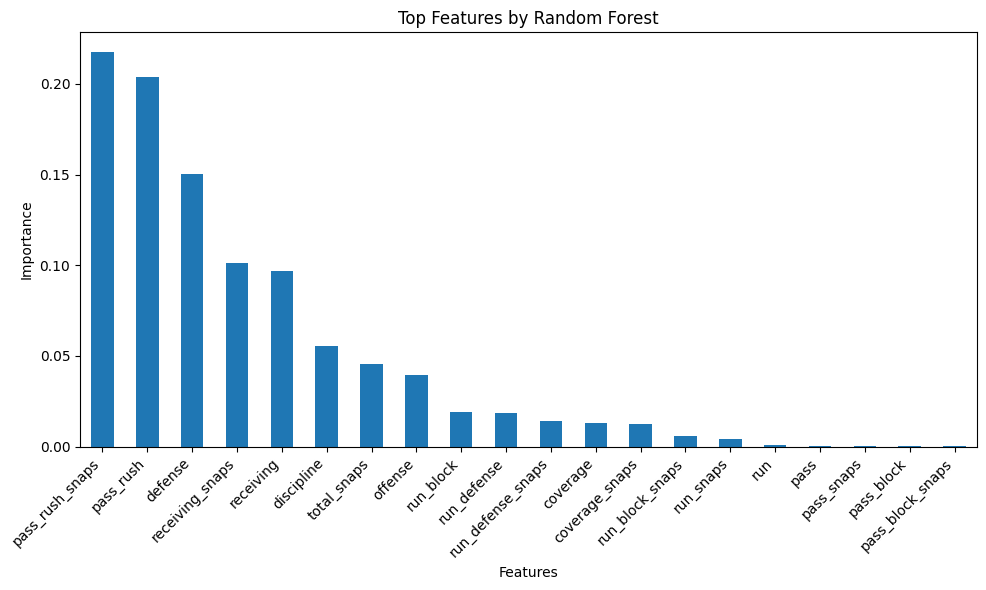

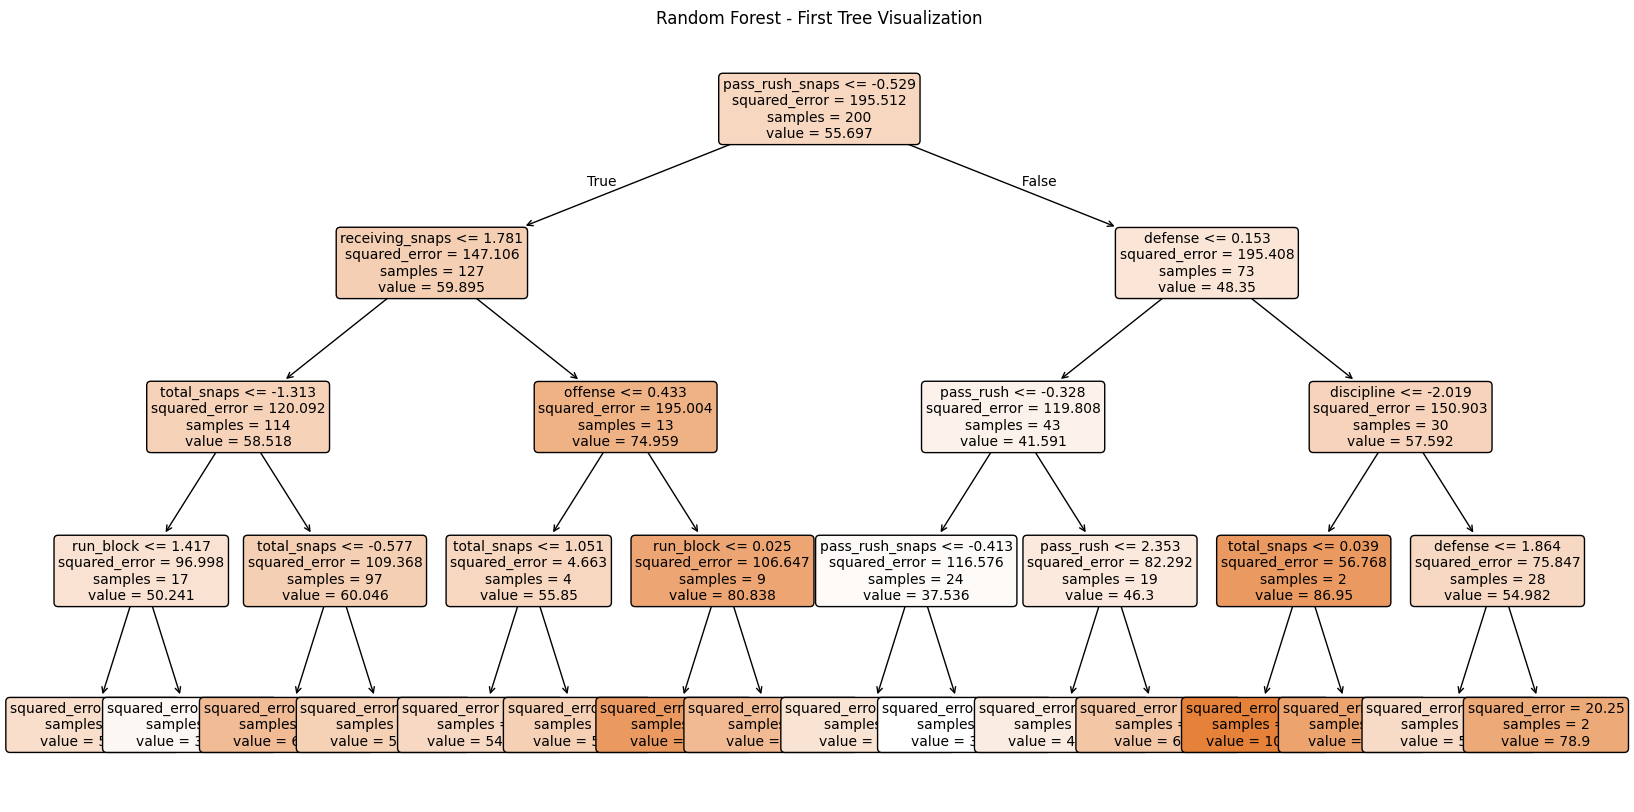

In [24]:
# ----------------------
# Random Forest model
# ----------------------
rf = RandomForestRegressor(n_estimators=500, max_depth=4, random_state=42)
rf.fit(X_train, y_train)

feature_importance_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
# print("\nTop features by Random Forest:")
# print(feature_importance_rf)

plt.figure(figsize=(10, 6))
feature_importance_rf.plot(kind='bar')
plt.title("Top Features by Random Forest")
plt.ylabel("Importance")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
# Plot the first tree in the forest
plot_tree(
    rf.estimators_[0],
    feature_names=X.columns,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Random Forest - First Tree Visualization")
plt.show()

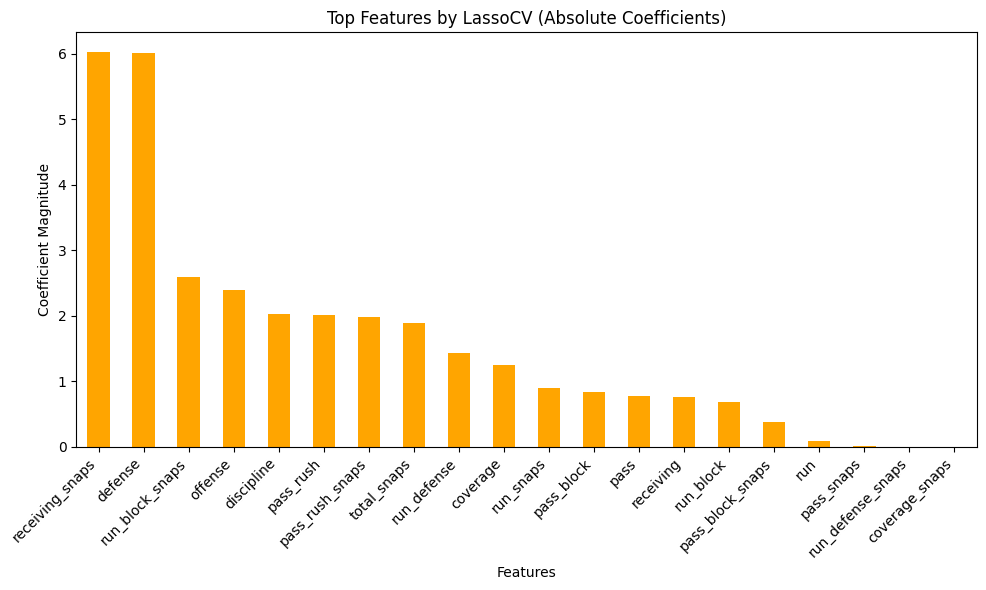

In [25]:
# ----------------------
# LassoCV model
# ----------------------
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Feature importance
feature_importance_lasso = pd.Series(lasso.coef_, index=X.columns).sort_values(ascending=False)
# print("Top features by LassoCV:")
# print(feature_importance_lasso)

plt.figure(figsize=(10, 6))
feature_importance_lasso_abs = feature_importance_lasso.abs().sort_values(ascending=False)
feature_importance_lasso_abs.plot(kind='bar', color='orange')
plt.title("Top Features by LassoCV (Absolute Coefficients)")
plt.ylabel("Coefficient Magnitude")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [22]:
clean_query = duckdb.query("""

SELECT DiSTINCT * 
FROM tot
ORDER BY position
""").to_df()

clean_query
clean_query.to_csv("clean_agged_season_stats.csv")